# Data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


In [2]:
# Load data file
df = pd.read_csv('terry-clean.csv')
pd.set_option('display.max_columns', 999)
df.head()

# Delete subject id

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,subject_age_group,subject_id,go_/_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_yob,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,reported_date,reported_time,initial_call_type,final_call_type,call_type,officer_squad,arrest_flag,frisk_flag,precinct,sector,beat
0,36 - 45,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,None,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,18 - 25,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,Unknown,-,2015-04-01T00:00:00,04:55:00,-,-,None,NaN,N,N,-,-,-
2,1 - 17,-1,20150000002451,46430,Field Contact,None,7591,1985,M,Hispanic or Latino,Unknown,-,2015-05-25T00:00:00,01:06:00,-,-,None,WEST PCT 3RD W - MARY,N,N,-,-,-
3,1 - 17,-1,20150000002815,51725,Field Contact,None,7456,1979,M,White,Unknown,-,2015-06-09T00:00:00,19:27:00,-,-,None,NORTH PCT 2ND W - NORA,N,N,-,-,-
4,26 - 35,-1,20150000002815,51727,Field Contact,None,7456,1979,M,White,Unknown,-,2015-06-09T00:00:00,19:32:00,-,-,None,NORTH PCT 2ND W - NORA,N,N,-,-,-


In [3]:
df.describe()

,subject_id,go_/_sc_num,terry_stop_id,officer_yob
count,4.031300e+04,4.031300e+04,4.031300e+04,40313.000000
mean,1.213040e+09,2.017155e+13,1.503510e+09,1982.277131
std,3.046154e+09,1.471057e+10,3.722270e+09,8.834036
min,-1.000000e+00,2.009000e+13,2.802000e+04,1900.000000
25%,-1.000000e+00,2.016000e+13,1.572900e+05,1977.000000
50%,-1.000000e+00,2.017000e+13,3.184670e+05,1984.000000
75%,-1.000000e+00,2.018000e+13,5.052170e+05,1989.000000
max,1.275286e+10,2.020000e+13,1.275287e+10,1997.000000


# Build a base model

First set the target: arrest flag

In [4]:
# Set target
y = df.arrest_flag
y = y.replace('N', 0).replace('Y', 1)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: arrest_flag, dtype: int64

## I will use a random forest with the top attributes to build a baseline model:
* frisk flag
* final call type
* subject age group
* reported time - will create categories manually

In [5]:
# Top features to try
X = df[['frisk_flag', 'call_type', 'subject_age_group', 'subject_perceived_gender', 'subject_perceived_race']]
X.head()

,frisk_flag,call_type,subject_age_group,subject_perceived_gender,subject_perceived_race
0,N,None,36 - 45,Male,Asian
1,N,None,18 - 25,-,Unknown
2,N,None,1 - 17,-,Unknown
3,N,None,1 - 17,-,Unknown
4,N,None,26 - 35,-,Unknown


In [6]:
# Create dummy variables
data = pd.get_dummies(X)
display(data.head())


,frisk_flag_-,frisk_flag_N,frisk_flag_Y,call_type_911,call_type_None,call_type_ONVIEW,call_type_Other,subject_age_group_1 - 17,subject_age_group_18 - 25,subject_age_group_26 - 35,subject_age_group_36 - 45,subject_age_group_46 - 55,subject_age_group_56 and Above,subject_perceived_gender_-,subject_perceived_gender_Female,subject_perceived_gender_Gender Diverse (gender non-conforming and/or transgender),subject_perceived_gender_Male,subject_perceived_gender_Unable to Determine,subject_perceived_gender_Unknown,subject_perceived_race_American Indian or Alaska Native,subject_perceived_race_Asian,subject_perceived_race_Black or African American,subject_perceived_race_Hispanic,subject_perceived_race_Multi-Racial,subject_perceived_race_Native Hawaiian or Other Pacific Islander,subject_perceived_race_Other,subject_perceived_race_Unknown,subject_perceived_race_White
0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Separate reported time

In [7]:
# Observe the hour
df.reported_time = df.reported_time.str[:2].astype('int')
df.reported_time.head()


0    11
1     4
2     1
3    19
4    19
Name: reported_time, dtype: int64

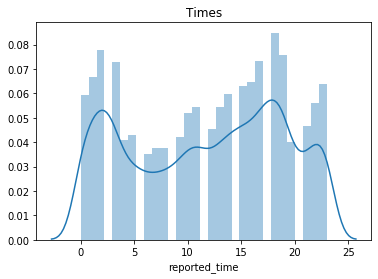

In [8]:
sns.distplot(df.reported_time)
plt.title('Times')
plt.show()

In [9]:
# Create bins
bins = [0, 6, 12, 18, 24]

# Use pd.cut()
bins_time = pd.cut(df.reported_time, bins)

# Using pd.cut() returns unordered categories. Transform th
bins_time = bins_time.cat.as_ordered() 
bins_time.head()

0     (6, 12]
1      (0, 6]
2      (0, 6]
3    (18, 24]
4    (18, 24]
Name: reported_time, dtype: category
Categories (4, interval[int64]): [(0, 6] < (6, 12] < (12, 18] < (18, 24]]

Text(0.5, 1.0, 'Time Bins')

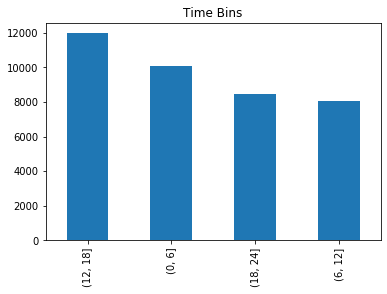

In [10]:
# Plot the values
bins_time.value_counts().plot(kind='bar')
plt.title('Time Bins')

In [11]:
# Replace the existing 
df.reported_time = bins_time

In [12]:
# Perfom label encoding
df.reported_time = df.reported_time.cat.codes
df.reported_time.head()

0    1
1    0
2    0
3    3
4    3
Name: reported_time, dtype: int8

In [13]:
# Add reported time category to other categoricals
data['reported_time'] = df.reported_time
data.head()

,frisk_flag_-,frisk_flag_N,frisk_flag_Y,call_type_911,call_type_None,call_type_ONVIEW,call_type_Other,subject_age_group_1 - 17,subject_age_group_18 - 25,subject_age_group_26 - 35,subject_age_group_36 - 45,subject_age_group_46 - 55,subject_age_group_56 and Above,subject_perceived_gender_-,subject_perceived_gender_Female,subject_perceived_gender_Gender Diverse (gender non-conforming and/or transgender),subject_perceived_gender_Male,subject_perceived_gender_Unable to Determine,subject_perceived_gender_Unknown,subject_perceived_race_American Indian or Alaska Native,subject_perceived_race_Asian,subject_perceived_race_Black or African American,subject_perceived_race_Hispanic,subject_perceived_race_Multi-Racial,subject_perceived_race_Native Hawaiian or Other Pacific Islander,subject_perceived_race_Other,subject_perceived_race_Unknown,subject_perceived_race_White,reported_time
0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
4,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3


# Train/test the data

In [14]:
# Split the train and test sets
data_train, data_test, target_train, target_test = train_test_split(data, y, 
                                                                    test_size = 0.25)

In [15]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(data_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
# Examine feature importance
display(tree_clf.feature_importances_)

array([0.        , 0.        , 0.00145422, 0.        , 0.69291473,
       0.        , 0.        , 0.04693773, 0.04609259, 0.00247473,
       0.00219377, 0.00125529, 0.00975763, 0.        , 0.00304269,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00281484, 0.01267576, 0.10233618, 0.05108727, 0.        ,
       0.        , 0.00123925, 0.        , 0.02372333])

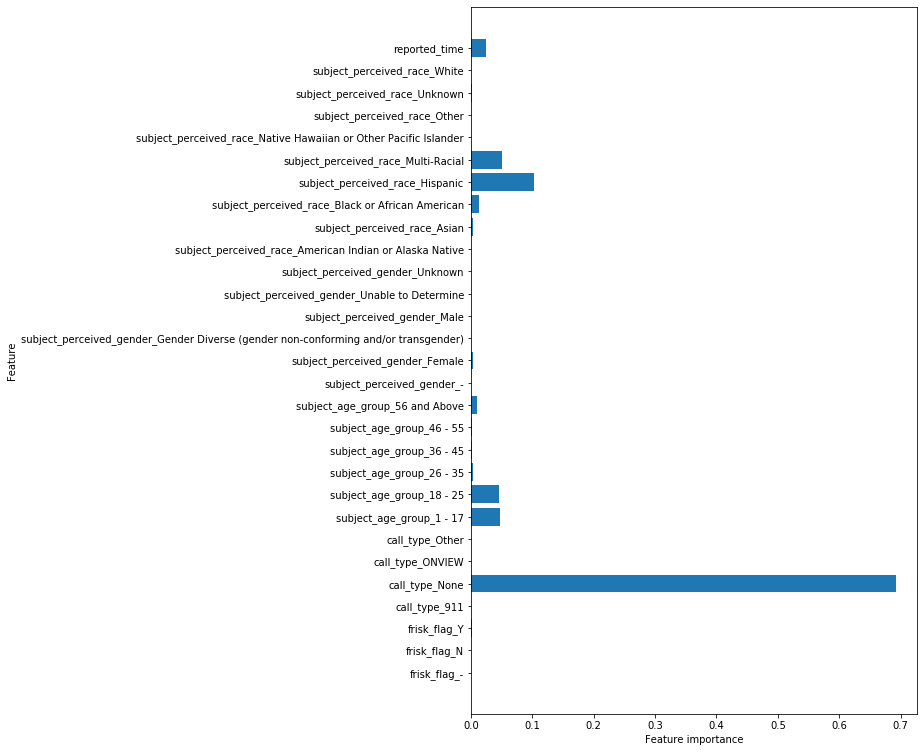

In [17]:
# Plot of the important features
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,13))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)


# Model Performance
Generate predictions, print out confusion matrix, and a classification report.

In [18]:
# Test set predictions
pred = tree_clf.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(target_test, pred))
print(classification_report(target_test, pred))

[[9704    0]
 [ 375    0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9704
           1       0.00      0.00      0.00       375

    accuracy                           0.96     10079
   macro avg       0.48      0.50      0.49     10079
weighted avg       0.93      0.96      0.94     10079



/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Bagged trees

In [19]:
# Instantiate a BaggingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

# Fit to training data
bagged_tree.fit(data_train, target_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [20]:
# Training accuracy score
scr = bagged_tree.score(data_train, target_train)
print('Training Accuracy: ' + str(scr))

# Test accuracy score
scr = bagged_tree.score(data_test, target_test)
print('Test Accuracy: ' + str(scr))

Training Accuracy: 0.9592842495204075
Test Accuracy: 0.9627939279690445


# Random Forest Model

In [21]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(data_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
# Training accuracy score
scr = forest.score(data_train, target_train)
print('Training Accuracy: ' + str(scr))

# Test accuracy score
scr = forest.score(data_test, target_test)
print('Test Accuracy: ' + str(scr))

Training Accuracy: 0.9592842495204075
Test Accuracy: 0.9627939279690445


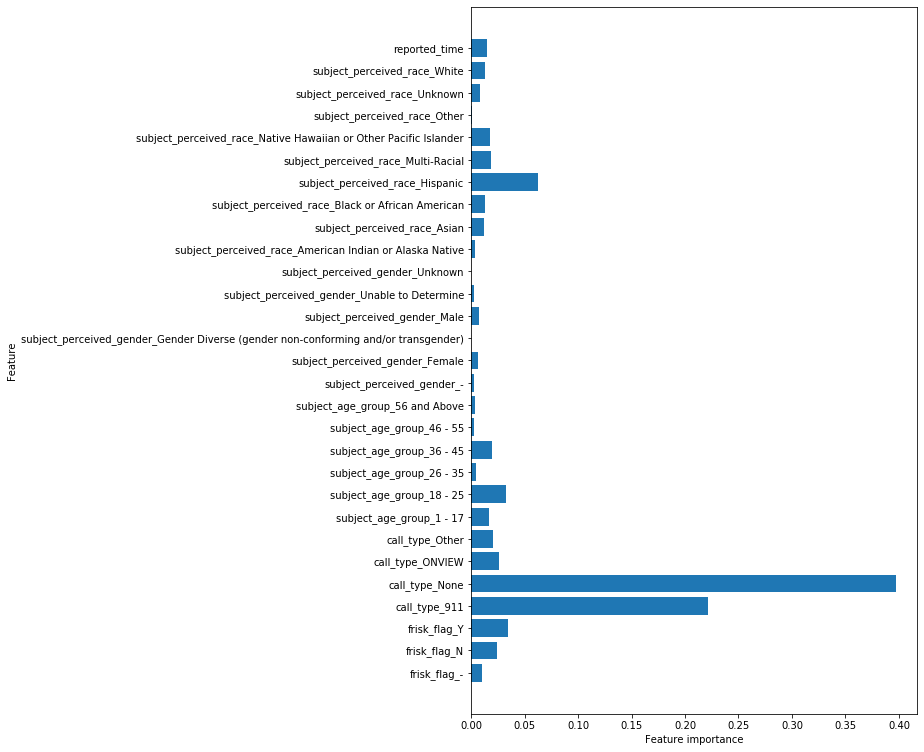

In [23]:
# Feature Importance
plot_feature_importances(forest)

## Trees in the forest

In [24]:
# Instantiate and fit a RandomForestClassifier
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(data_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

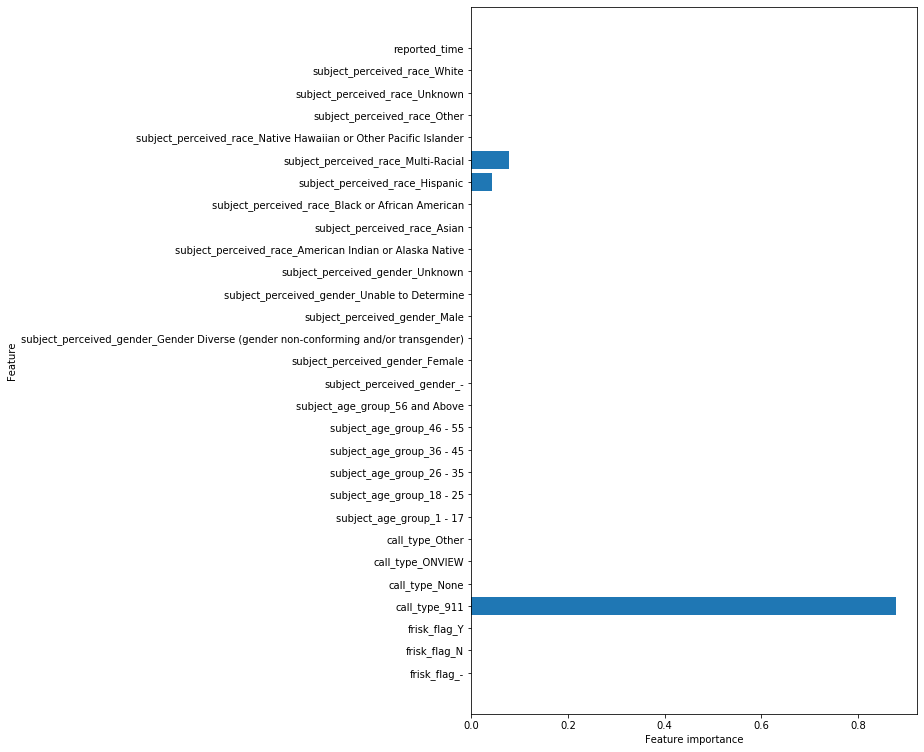

In [25]:
# First tree from forest_2
rf_tree_1 = forest_2.estimators_[0]

# Feature importance
plot_feature_importances(rf_tree_1)

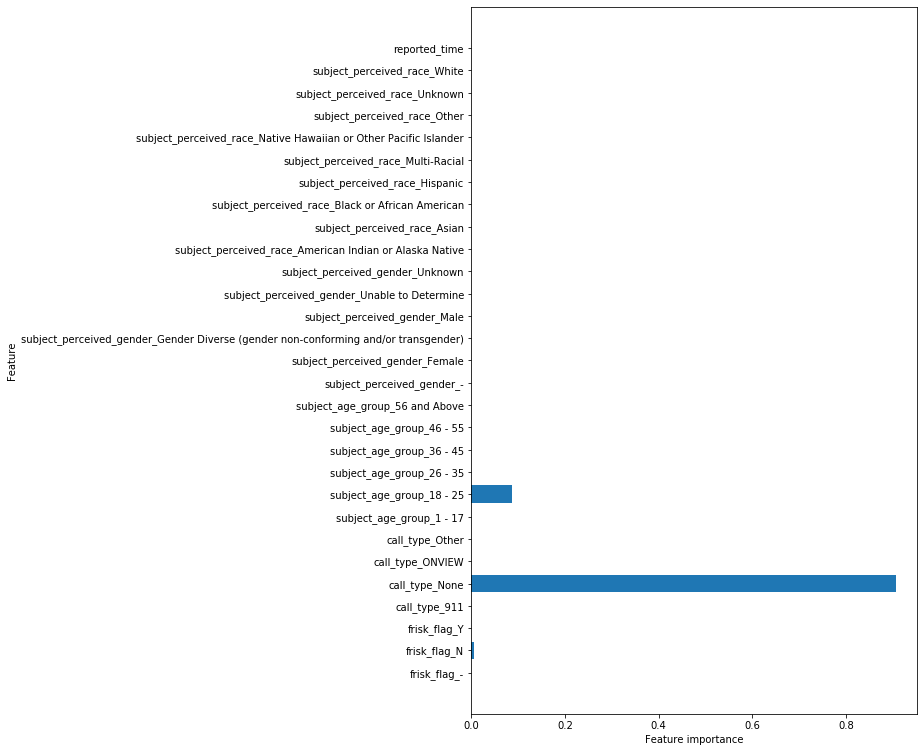

In [26]:
# Second tree from forest_2
rf_tree_2 = forest_2.estimators_[1]

# Feature importance
plot_feature_importances(rf_tree_2)

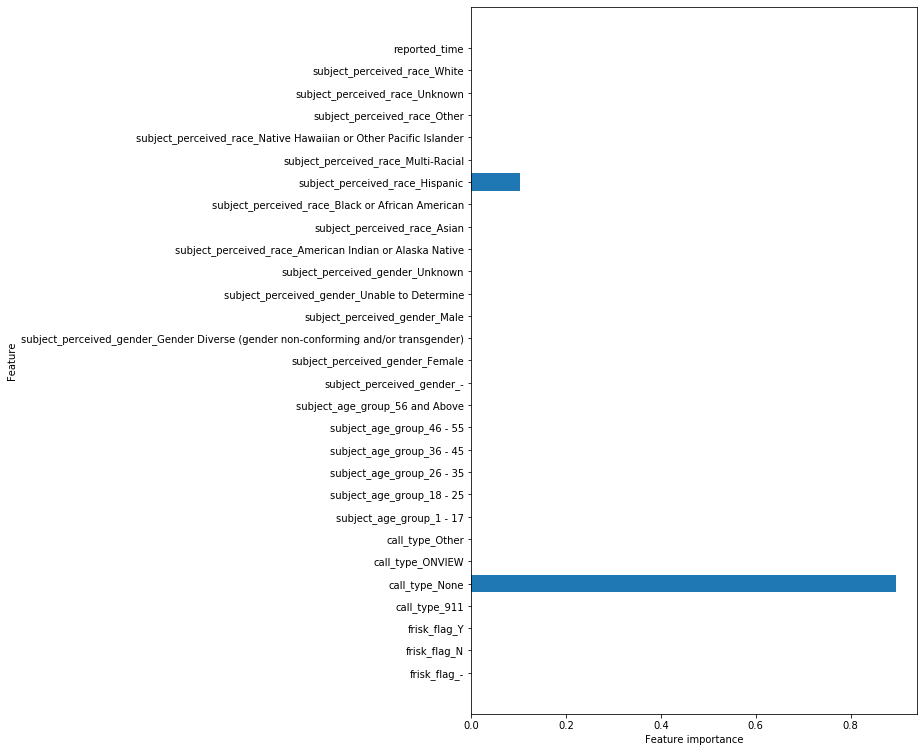

In [27]:
# Third tree from forest_2
rf_tree_3 = forest_2.estimators_[2]

# Feature importance
plot_feature_importances(rf_tree_3)

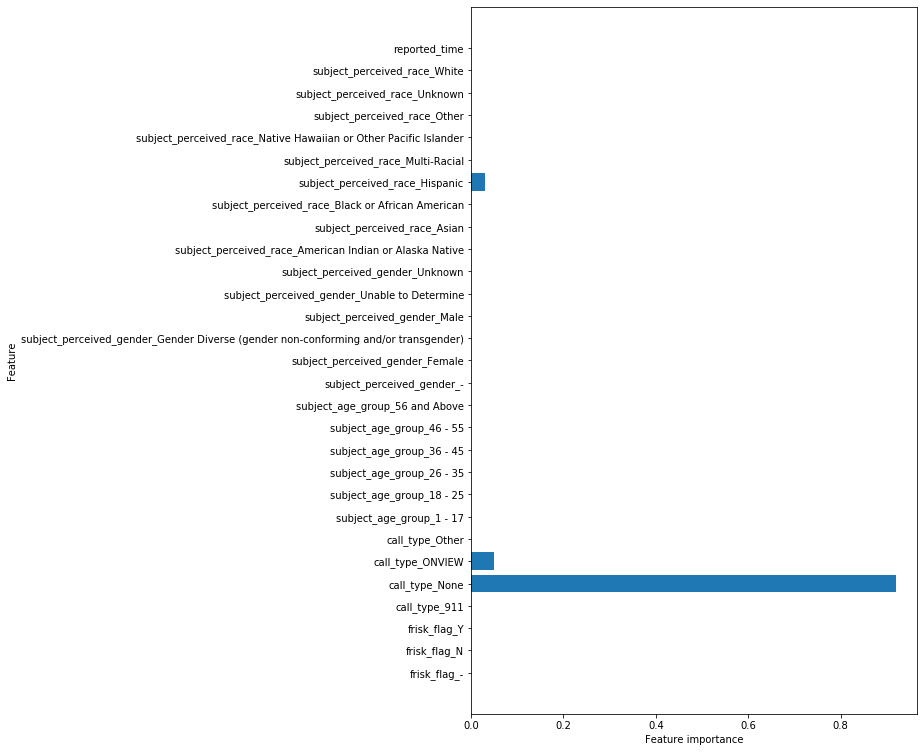

In [28]:
# Fourth tree from forest_2
rf_tree_4 = forest_2.estimators_[3]

# Feature importance
plot_feature_importances(rf_tree_4)

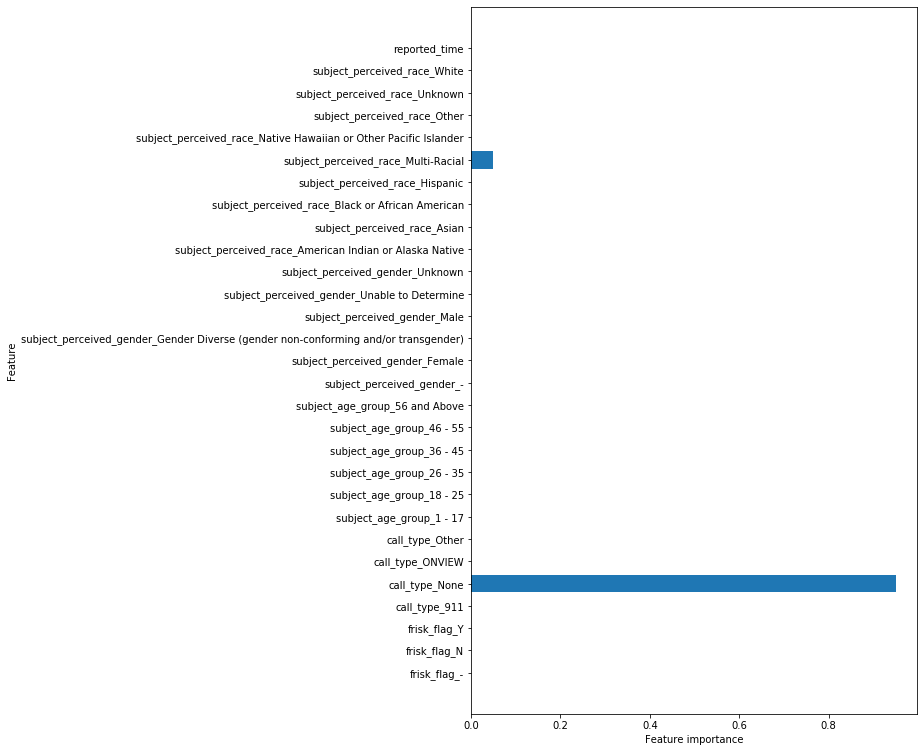

In [29]:
# Fifth tree from forest_2
rf_tree_5 = forest_2.estimators_[4]

# Feature importance
plot_feature_importances(rf_tree_5)

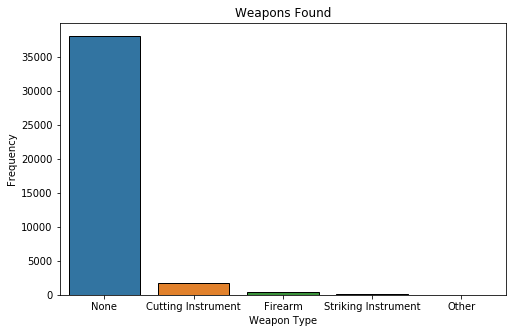

In [30]:
# Create histogram of weapon types
plt.figure(figsize=(8,5))
sns.countplot(df.weapon_type, edgecolor='black')
plt.xlabel('Weapon Type')
plt.ylabel('Frequency')
plt.title('Weapons Found')
plt.show()
